In [1]:
import math
import matplotlib.pyplot as plt
from visTools_v2.core_functions.operations.get_patches import get_patches

%load_ext autoreload
%autoreload 2
%matplotlib inline


# Helper functions:

In [2]:
from visTools_v2.core_functions.kernels.kernels import kernel
from visTools_v2.core_functions.kernels.gaussian_filter import GaussianFilter
from visTools_v2.core_functions.operations.img_grad import img_grad
from visTools_v2.core_functions.operations.normalize import norm
from visTools_v2.core_functions.operations.reduce_expand import Reduce_stack
from visTools_v2.core_functions.operations.get_patches import *


In [3]:
def load_img(img):
    im = plt.imread(img)
    im = np.moveaxis(im,2,0)
    im = np.mean(im,axis=0)
    im = im[np.newaxis,np.newaxis,:,:]
    return im

In [4]:
def build_H(I):
    xks = np.indices(np.array(I.R)[:,np.newaxis,:,:].shape).reshape((4,-1))

    patches = get_patches(np.array(I.R)[:,np.newaxis,:,:]
                          .astype(np.float64),
                          xks.T.astype(np.float64),h=3,w=3)
    
    Ixy = patches[0]*patches[1]
    Ixx,Iyy = patches**2

    Ixx = np.sum(Ixx,axis=(2,3,4))
    Iyy = np.sum(Iyy,axis=(2,3,4))
    Ixy = np.sum(Ixy,axis=(2,3,4))

    H = np.stack([[Ixx,Ixy],[Ixy,Iyy]])
    H = np.moveaxis(H,0,3)
    return np.moveaxis(H,0,3)



# Harris Detector

In [5]:
class Harris_detector:
    def __init__(self,img):
        self.img = img
            
    def solve(self,solve=False,blur_window=(3,3),deriv_type=kernel().fd,
                                          sig=1,Red=0,sharp=False,
                                          blur=True,
                         second_moment_window=(3,3),
                        clusters=None,
                        th=0.03):
       
        self.second_moment_window=second_moment_window
        self.th = th
        
        self.im = load_img(self.img)
        self.im = Reduce_stack(self.im,Red)
        
        
        I = img_grad(self.im)
        I.get_grad(th=th,
                      blur=blur,
                      h=blur_window[0],
                      w=blur_window[1],
                      sig=sig,
                      sharp=sharp,g=deriv_type,
                      Red=0)
        
        self.im_shape = I.S.shape
        self.I = I
        self.compute()
        
    
    def compute(self):
        self.H = build_H(self.I)
        self.R = self.get_corner_response(self.H)
        self.apply_threshold(self.R)


    def get_corner_response(self,H):
        
        U,S,V = np.linalg.svd(H.reshape((-1,2,2)))
        alpha=0.06
        self.S=S
        R = S[:,0]*S[:,1] - alpha*(S[:,0]+S[:,1])**2
        R = R.reshape(img1.im_shape)
        return R

    def apply_threshold(self,R_):
        th = self.th
     
    
        R_[R_<th]=0
        
        R_ = self.nonMaxSup(R_)
        
        xk = np.argwhere(R_)
       
        plt.scatter(xk[:,1],xk[:,0],c='r',s=0.5)
        plt.imshow(self.im[0,0,:,:],**{'cmap':'gray'})
        plt.show()
        self.xk = xk

    def edges(self):
        ed = self.R
        ed[ed<0]=0
        plt.imshow(ed)
        
    def nonMaxSup(self,S):
        n = self.I.n
        S_padded = np.pad(S,((1,1),(1,1)),'mean')
        kp = np.argwhere(S)

        n0 = n[:,kp[:,0],kp[:,1]].T

        q0 = kp+n0*1/(2*math.sin(math.pi/8)) 
        q1 = kp-n0*1/(2*math.sin(math.pi/8)) 

        q0 = np.round(q0).astype(int)
        q1 = np.round(q1).astype(int)

        maxs = (S[kp[:,0],kp[:,1]]>S_padded[q0[:,0],q0[:,1]])| (S[kp[:,0],kp[:,1]]>S_padded[q1[:,0],q1[:,1]])

        maxs = kp[maxs]
        new_S = np.zeros_like(S)
        new_S[maxs[:,0],maxs[:,1]]=1
        return new_S
        

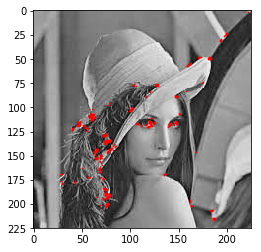

In [6]:
img1 = Harris_detector("img/canny.jpeg")
img1.solve(Red=0,th=.01)

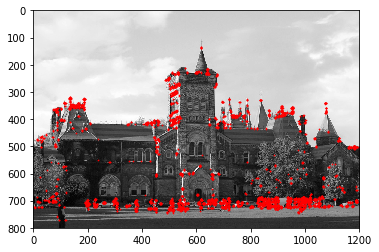

In [7]:
img1 = Harris_detector("img/uoft2.jpg")
img1.solve(Red=0,th=.03,clusters=100)

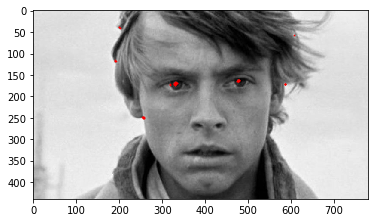

In [8]:
img1 = Harris_detector("img/luke.jpg")
img1.solve(Red=0,th=.003)

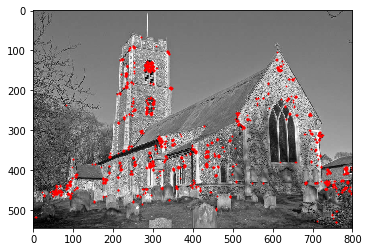

In [9]:
img1 = Harris_detector("img/church.jpg")
img1.solve(Red=0,th=.03)

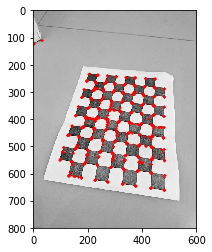

(2435, 2)


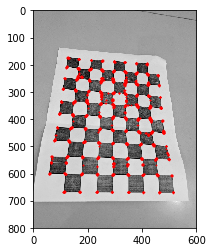

(2392, 2)


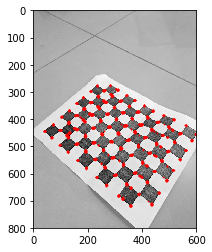

(2203, 2)


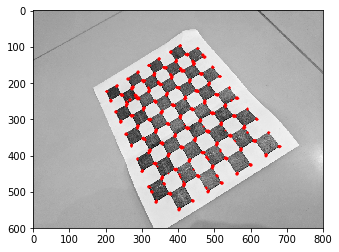

(2090, 2)


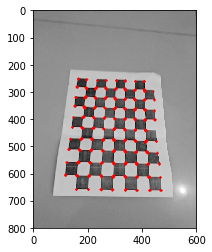

(1289, 2)


In [10]:
import os
imgs = os.listdir("img/calibration/")
img = []
n=0
for i in imgs:
    img1 = Harris_detector(os.path.join(
    "img/calibration/",i))
    img1.solve(th=.3,clusters=98,Red=1,sharp=True)
    print(img1.xk.shape)
    n+=1